In [3]:
import numpy as np
import pandas as pd
import pickle
import time
import os
import csv
import shutil
import sys
import statistics

import SimpleITK as sitk
import matplotlib.pyplot as plt
import pydicom
import imageio
import glob
import boto3

from lungmask import LMInferer

In [3]:
#!pip install lungmask

In [4]:
import torch
torch.cuda.empty_cache()

## Function to resample the CT scan volume to a given voxel size

In [4]:
def resample_volume(volume_path, interpolator = sitk.sitkLinear, new_spacing = [1,1, 1]):
    volume = sitk.ReadImage(volume_path) # read and cast to float32
    original_spacing = volume.GetSpacing()
    original_size = volume.GetSize()
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    return sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
                         volume.GetOrigin(), new_spacing, volume.GetDirection(), interpolator,
                         volume.GetPixelID())

## Functions to Segment Lungs from CT Scan

In [5]:
def inferer_mask(ct_scan_volume, offset=0):
    '''
    Input is 3D numpy array of original CT scan and output is 3D numpy array of generated mask
    '''
    inferer = LMInferer()
    #Defines numpy offset to allow segmentation to work across different datasets (LUNA16 doesn't need)
    ct_scan_volume -= offset
    mask_slices = []
    lung_mask_volume = inferer.apply(ct_scan_volume)
    for slice_idx in range(ct_scan_volume.shape[0]):
        mask_slices.append(lung_mask_volume[slice_idx, :, :])

    mask_slices = np.stack(mask_slices, axis=0)
    
    return mask_slices

In [6]:
def segmented_inferer_volume(ct_scan,offset=0):
    '''
    Input is 3D numpy array of original CT scan and output is 3D numpy array of segmented volume
    '''
    #Defines numpy offset to allow segmentation to work across different datasets (LUNA16 doesn't need)
    ct_scan -= offset
    print('max:',ct_scan.max())
    print('min:',ct_scan.min())
    lung_mask_volume = inferer_mask(ct_scan)
    segmented_slices = []
    tracker = []
    for slice_idx in range(ct_scan.shape[0]):
        ct_slice = ct_scan[slice_idx, :, :]
        lung_mask_slice = lung_mask_volume[slice_idx, :, :]
        masked_slice = np.where(lung_mask_slice != 0, ct_slice, np.min(ct_slice))
        segmented_slices.append(masked_slice)
        
        #keeps track of value ranges only in lungs
        tracker_slice = np.where(lung_mask_slice != 0, ct_slice, -99999)
        tracker.append(tracker_slice)
        
    segmented_slices = np.stack(segmented_slices, axis=0)
    
    # Concatenate the arrays into a single array
    concatenated_array = np.concatenate(tracker)
    
    # Filter the array to exclude values equal to -99999
    concatenated_array  = concatenated_array[concatenated_array  != -99999]

    # Find the minimum and maximum values inside lung volume
    min_value = np.min(concatenated_array)
    max_value = np.max(concatenated_array)

    # Normalize the segmented volume to a range of 0 to 1
    segmented_slices = (segmented_slices - min_value) / (max_value - min_value)
    
    #Replace background with 0's
    background_value = segmented_slices[0][0][0]
    segmented_slices = np.where(segmented_slices == background_value, 0, segmented_slices)
    
    
    return segmented_slices

In [7]:
def remove_blank_slices(segmented_ct_scan,ct_scan=None):
    '''
    Input is 3D numpy array of segmented volume and output is numpy array slices that only contain lung volume
    
    If ct_scan file is added, it will remove the correlated slice from the original CT scan for comparison
    '''
    segment_result = []
    ct = []
    # Iterate through each slice 
    for slice_2d in range(segmented_ct_scan.shape[0]):
        # Check if all elements in the slice have the same value
        if not np.all(segmented_ct_scan[slice_2d] == segmented_ct_scan[slice_2d][0]):
            segment_result.append(segmented_ct_scan[slice_2d, :, :])
            if ct_scan is not None:
                ct.append(ct_scan[slice_2d, :, :])

    # Convert the result back to a NumPy array
    segment_result = np.stack(segment_result, axis=0)
    
    if ct_scan is not None:
        ct = np.stack(ct, axis=0)
        return segment_result, ct
    else:
        return segment_result

## Check Contents of Upload Folder

In [8]:
def check_dicom_folder(dicom_dir):
    # Check if the directory contains .dcm files
    dicom_files = [file for file in os.listdir(dicom_dir) if file.endswith(".dcm")]
    if not dicom_files:
        print(f"No DICOM files found in directory: {dicom_dir}")
        return

    # Check if the folder has more than 10 files
    if len(dicom_files) <= 10:
        print(f"Insufficient number of files in directory: {dicom_dir}")
        return
    
    # Load all DICOM files in the directory
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, file)) for file in dicom_files]

    # Sort the DICOM files based on the filename
    dicom_files.sort(key=lambda x: x.filename)

    # Get the pixel arrays from the DICOM files
    slices = [dicom_file.pixel_array for dicom_file in dicom_files]

    # Convert the list of pixel arrays to a 3D numpy array
    ct_scan = np.stack(slices)

    return ct_scan

## Pull Metadata from .DCM files

In [9]:
def process_dicom_folder(dicom_dir):
    # Check if the directory contains .dcm files
    dicom_files = [file for file in os.listdir(dicom_dir) if file.endswith(".dcm")]

    # Load all DICOM files in the directory
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, file)) for file in dicom_files]

    # Sort the DICOM files based on the filename
    dicom_files.sort(key=lambda x: x.filename)

    # Get the pixel arrays from the DICOM files
    slices = [dicom_file.pixel_array.astype(np.int16) for dicom_file in dicom_files]

    # Convert the list of pixel arrays to a 3D numpy array
    ct_scan = np.stack(slices)
    
    # Ensure that no value exceeds 5000
    ct_scan = np.clip(ct_scan, a_min=None, a_max=5000)

    # Normalize the values to a range between -3000 and 3000
    #ct_scan = ((ct_scan - ct_scan.min()) / (ct_scan.max() - ct_scan.min())) * 2000 - 1000
    
    dicom = pydicom.dcmread((os.path.join(dicom_dir, os.listdir(dicom_dir)[0])))
    
    thickness = float(dicom.SliceThickness)
    pixel_x, pixel_y = dicom.PixelSpacing
    
    spacing = (float(pixel_x),float(pixel_y), float(thickness))
    
    origins_x = [dicom_file.ImagePositionPatient[0] for dicom_file in dicom_files]
    origins_y = [dicom_file.ImagePositionPatient[1] for dicom_file in dicom_files]
    origins_z = [dicom_file.ImagePositionPatient[2] for dicom_file in dicom_files]
    
    origin = (float(statistics.mean(origins_x)), float(statistics.mean(origins_y)),float(statistics.mean(origins_z)))

    print('Min:', ct_scan.min())
    print('Max:', ct_scan.max())
    print('origin:', origin)
    print('spacing:', spacing)
    return ct_scan, origin, spacing

## Segment function to Call 

In [12]:
def segment_single_scan(root_dir,output_file_path,mhd_file_name,voxel_size=2):
    #Initialize lungmask inferer
    inferer = LMInferer()

    # Get a list of all files in the root directory
    all_files = os.listdir(root_dir)

    # Filter DICOM files
    dicom_files = [filename for filename in all_files if filename.endswith(".dcm")]

    # Filter mhd files
    mhd_files = [filename for filename in all_files if filename.endswith(".mhd")]

    cube_length = 512/voxel_size

    # Check if there are any DICOM files in the root_dir
    if len(dicom_files) > 0 and len(dicom_files) == len(all_files):
        print("Segmenting .dcm files...")
        mhd_file = check_dicom_folder(root_dir)
        if isinstance(mhd_file, np.ndarray):
            mhd_file, origin, spacing = process_dicom_folder(root_dir)
            image_sitk = sitk.GetImageFromArray(mhd_file)
            sitk.WriteImage(image_sitk, output_file_path + '/'+ mhd_file_name +'.mhd')
            volume = sitk.ReadImage( output_file_path +  '/'+ mhd_file_name+'.mhd') # read and cast to float32
            volume = sitk.Cast(volume, sitk.sitkInt16)
            volume.SetSpacing(spacing)
            volume.SetOrigin(origin)
            sitk.WriteImage(volume, output_file_path +'/'+ mhd_file_name +'.mhd')
            # Use glob to retrieve a list of .mhd file paths within the input folder
            mhd_file_paths = glob.glob(os.path.join(output_file_path, '*.mhd'))

    elif len(mhd_files) > 0 and len(dicom_files)==0:
        print("Segmenting .mhd file...")
        mhd_file_paths = glob.glob(os.path.join(root_dir, '*.mhd'))

    elif len(mhd_files) > 0 and len(dicom_files) > 0:
        print("Folder contains both .mhd and .dcm files. Please upload only one scan at a time.")
        sys.exit()

    # Normalize voxel size for each file, segment lungs, and save as new file
    for file_path in mhd_file_paths:
        ct_scan_resampled = resample_volume(file_path,new_spacing = [voxel_size, voxel_size, voxel_size])
        file_name = os.path.basename(file_path)  # Get the file name
        #output_file_path = os.path.join(output_folder_path, file_name)
        #sitk.WriteImage(ct_scan_resampled, output_file_path)
        ct_scan_resampled = np.array(sitk.GetArrayFromImage(ct_scan_resampled), dtype=np.float32)

        min_value = ct_scan_resampled.min()
        max_value = ct_scan_resampled.max()
        ct_scan_resampled = 6000 * ((ct_scan_resampled - min_value) / (max_value - min_value)) - 3000

        unet_segmented_volume = segmented_inferer_volume(ct_scan_resampled)
        unet_trimmed_volume = remove_blank_slices(unet_segmented_volume)
        min_value = np.min(unet_trimmed_volume)

        # Define the target shape
        target_shape = (int(cube_length), int(cube_length), int(cube_length))

        # Calculate the required padding for each dimension
        pad_depth = max(target_shape[0] - unet_trimmed_volume.shape[0], 0)
        pad_height = max(target_shape[1] - unet_trimmed_volume.shape[1], 0)
        pad_width = max(target_shape[2] - unet_trimmed_volume.shape[2], 0)

        # Calculate the padding amounts for each side of each dimension
        pad_depth_before = pad_depth // 2
        pad_depth_after = pad_depth - pad_depth_before

        pad_height_before = pad_height // 2
        pad_height_after = pad_height - pad_height_before

        pad_width_before = pad_width // 2
        pad_width_after = pad_width - pad_width_before

        # Pad the array with the minimum value
        padded_data = np.pad(unet_trimmed_volume, ((pad_depth_before, pad_depth_after), (pad_height_before, pad_height_after), (pad_width_before, pad_width_after)), mode='constant', constant_values=min_value)

        #normalize all values to be between 0 and 1
        padded_data_norm = (padded_data-np.min(padded_data))/(np.max(padded_data)-np.min(padded_data))

        image_sitk = sitk.GetImageFromArray(padded_data_norm)
        #image_sitk = sitk.Cast(image_sitk, sitk.sitkInt16)
        sitk.WriteImage(image_sitk, output_file_path + '/' + mhd_file_name+'_segmented.mhd')
        

        print('done')


## Testing Cells

In [13]:
segment_single_scan('Radiogenomics/mhd_files', 'Radiogenomics/user_output_test', 'test_2mm', 2)   

lungmask 2023-07-27 16:28:12 No GPU found, using CPU instead
Segmenting .mhd file...
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:28:13 No GPU found, using CPU instead


12it [01:16,  6.36s/it]                           

lungmask 2023-07-27 16:29:31 Postprocessing



100%|██████████| 53/53 [00:00<00:00, 81.49it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:29:35 No GPU found, using CPU instead


9it [00:55,  6.18s/it]                         

lungmask 2023-07-27 16:30:31 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 87.68it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:30:34 No GPU found, using CPU instead


104%|██████████| 7/6.7 [00:45<-1:59:59,  6.50s/it]

lungmask 2023-07-27 16:31:20 Postprocessing



100%|██████████| 636/636 [00:08<00:00, 75.28it/s]  


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:31:31 No GPU found, using CPU instead


7it [00:44,  6.30s/it]                         

lungmask 2023-07-27 16:32:16 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 122.89it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:32:20 No GPU found, using CPU instead


107%|██████████| 6/5.6 [00:37<-1:59:58,  6.27s/it]

lungmask 2023-07-27 16:32:58 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 180.25it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:33:02 No GPU found, using CPU instead


106%|██████████| 6/5.65 [00:38<-1:59:58,  6.39s/it]

lungmask 2023-07-27 16:33:41 Postprocessing



100%|██████████| 552/552 [00:07<00:00, 77.49it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:33:51 No GPU found, using CPU instead


7it [00:42,  6.10s/it]                          

lungmask 2023-07-27 16:34:35 Postprocessing



100%|██████████| 373/373 [00:05<00:00, 71.28it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:34:44 No GPU found, using CPU instead


6it [00:36,  6.10s/it]                          

lungmask 2023-07-27 16:35:21 Postprocessing



100%|██████████| 624/624 [00:07<00:00, 83.44it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:35:31 No GPU found, using CPU instead


103%|██████████| 4/3.9 [00:26<00:00,  6.52s/it]

lungmask 2023-07-27 16:35:58 Postprocessing



100%|██████████| 40/40 [00:00<00:00, 115.88it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:36:01 No GPU found, using CPU instead


7it [00:41,  5.87s/it]                          

lungmask 2023-07-27 16:36:43 Postprocessing



100%|██████████| 886/886 [00:11<00:00, 77.73it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:36:58 No GPU found, using CPU instead


105%|██████████| 8/7.6 [00:51<-1:59:58,  6.49s/it]

lungmask 2023-07-27 16:37:51 Postprocessing



100%|██████████| 51/51 [00:00<00:00, 62.43it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:37:56 No GPU found, using CPU instead


106%|██████████| 6/5.65 [00:38<-1:59:58,  6.34s/it]

lungmask 2023-07-27 16:38:34 Postprocessing



100%|██████████| 519/519 [00:05<00:00, 90.91it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:38:44 No GPU found, using CPU instead


7it [00:42,  6.14s/it]                         

lungmask 2023-07-27 16:39:28 Postprocessing



100%|██████████| 622/622 [00:09<00:00, 64.41it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:39:40 No GPU found, using CPU instead


100%|██████████| 3/3.0 [00:20<00:00,  6.78s/it]

lungmask 2023-07-27 16:40:00 Postprocessing



100%|██████████| 29/29 [00:00<00:00, 147.43it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:40:04 No GPU found, using CPU instead


7it [00:41,  5.92s/it]                         

lungmask 2023-07-27 16:40:46 Postprocessing



100%|██████████| 605/605 [00:08<00:00, 71.16it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:40:58 No GPU found, using CPU instead


7it [00:41,  5.92s/it]                          

lungmask 2023-07-27 16:41:40 Postprocessing



100%|██████████| 587/587 [00:07<00:00, 78.99it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:41:51 No GPU found, using CPU instead


100%|██████████| 6/6.0 [00:41<00:00,  6.85s/it]

lungmask 2023-07-27 16:42:33 Postprocessing



100%|██████████| 814/814 [00:10<00:00, 75.63it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:42:46 No GPU found, using CPU instead


106%|██████████| 7/6.6 [00:44<-1:59:58,  6.35s/it]

lungmask 2023-07-27 16:43:31 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 92.18it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:43:34 No GPU found, using CPU instead


7it [00:42,  6.01s/it]                         

lungmask 2023-07-27 16:44:17 Postprocessing



100%|██████████| 105/105 [00:01<00:00, 104.90it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:44:22 No GPU found, using CPU instead


7it [00:43,  6.23s/it]                         

lungmask 2023-07-27 16:45:06 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 116.01it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:45:09 No GPU found, using CPU instead


4it [00:21,  5.37s/it]                         

lungmask 2023-07-27 16:45:31 Postprocessing



100%|██████████| 321/321 [00:02<00:00, 141.60it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:45:36 No GPU found, using CPU instead


100%|██████████| 6/6.0 [00:40<00:00,  6.69s/it]

lungmask 2023-07-27 16:46:17 Postprocessing



100%|██████████| 568/568 [00:04<00:00, 118.58it/s] 


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:46:25 No GPU found, using CPU instead


6it [00:36,  6.03s/it]                         

lungmask 2023-07-27 16:47:02 Postprocessing



100%|██████████| 645/645 [00:08<00:00, 71.76it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:47:15 No GPU found, using CPU instead


7it [00:41,  5.87s/it]                         

lungmask 2023-07-27 16:47:56 Postprocessing



100%|██████████| 650/650 [00:10<00:00, 60.09it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:48:10 No GPU found, using CPU instead


4it [00:21,  5.36s/it]                         

lungmask 2023-07-27 16:48:32 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 177.62it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:48:34 No GPU found, using CPU instead


4it [00:23,  5.76s/it]                          

lungmask 2023-07-27 16:48:57 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 648.42it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:48:59 No GPU found, using CPU instead


4it [00:20,  5.19s/it]                         

lungmask 2023-07-27 16:49:20 Postprocessing



100%|██████████| 346/346 [00:02<00:00, 156.30it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:49:26 No GPU found, using CPU instead


7it [00:42,  6.01s/it]                         

lungmask 2023-07-27 16:50:09 Postprocessing



100%|██████████| 448/448 [00:06<00:00, 70.18it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:50:18 No GPU found, using CPU instead


100%|██████████| 3/3.0 [00:20<00:00,  6.78s/it]

lungmask 2023-07-27 16:50:39 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 1180.83it/s]


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:50:42 No GPU found, using CPU instead


103%|██████████| 6/5.8 [00:39<-1:59:59,  6.60s/it]

lungmask 2023-07-27 16:51:22 Postprocessing



100%|██████████| 624/624 [00:07<00:00, 84.24it/s]  


done
max: 3000.0
min: -3000.0
lungmask 2023-07-27 16:51:33 No GPU found, using CPU instead


  0%|          | 0/6.7 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [107]:
#segment_single_scan('SPIE/testing/4.000000-HIGH RES-47.17', 'SPIE/test_out', 'test', 1)   

(256, 256, 256)
1.0
0.0
(1.0, 1.0, 1.0)
(256, 256, 256)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
8


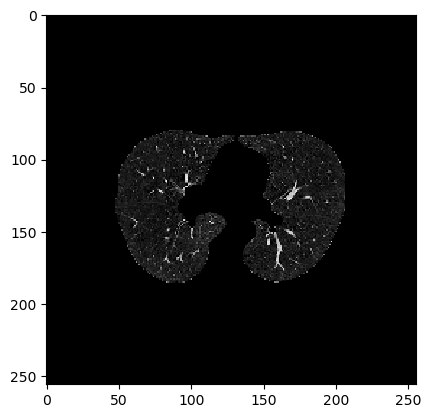

In [22]:

mhd_file = sitk.ReadImage('Radiogenomics/user_output_test/10.000000-1.25MM CHEST BONE PLUS-69796.mhd_segmented.mhd')
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
print(ct_scan.shape)
print(ct_scan.max())
print(ct_scan.min())
print(mhd_file.GetSpacing())
print(mhd_file.GetSize())
print(mhd_file.GetOrigin())
print(mhd_file.GetDirection())
print(mhd_file.GetPixelID())

# Displays an image slice
plt.imshow(ct_scan[128], cmap='gray')
plt.show()


#ct_seg = segmented_inferer_volume(ct_scan,offset=2000)
# Displays an image slice
#plt.imshow(ct_seg[120], cmap='gray')
#plt.show()